Imports

In [65]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.datasets import fetch_lfw_people

In [66]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Load data

In [2]:
from torchvision.datasets import ImageFolder
from datasets import load_dataset, Audio

In [3]:
# importing dependencies
import transformers
from datasets import load_dataset
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoProcessor, AutoModelForCausalLM, TrainingArguments, Trainer, EncoderDecoderModel
from evaluate import load
import torch
from PIL import Image
import requests
from datasets import  ClassLabel
from typing import Tuple

import datasets

In [4]:
dataset = load_dataset("imagefolder", data_dir='../datasets/vgg/')

Resolving data files:   0%|          | 0/169396 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/empar/.cache/huggingface/datasets/imagefolder/default-d22c4047e78bd24b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
dataset = dataset['train'].train_test_split(test_size=0.2)

In [6]:
train_data = dataset['train']
test_data = dataset['test']

In [7]:
input_list = train_data['label']
# taking an input list
l1 = []
 
# taking an counter
count = 0
 
# traversing the array
for item in input_list:
    if item not in l1:
        count += 1
        l1.append(item)
 
# printing the output
print("No of unique items are:", count)

No of unique items are: 500


In [8]:
input_list = test_data['label']
# taking an input list
l1 = []
 
# taking an counter
count = 0
 
# traversing the array
for item in input_list:
    if item not in l1:
        count += 1
        l1.append(item)
 
# printing the output
print("No of unique items are:", count)

No of unique items are: 500


In [9]:
train_data[1]["label"]

155

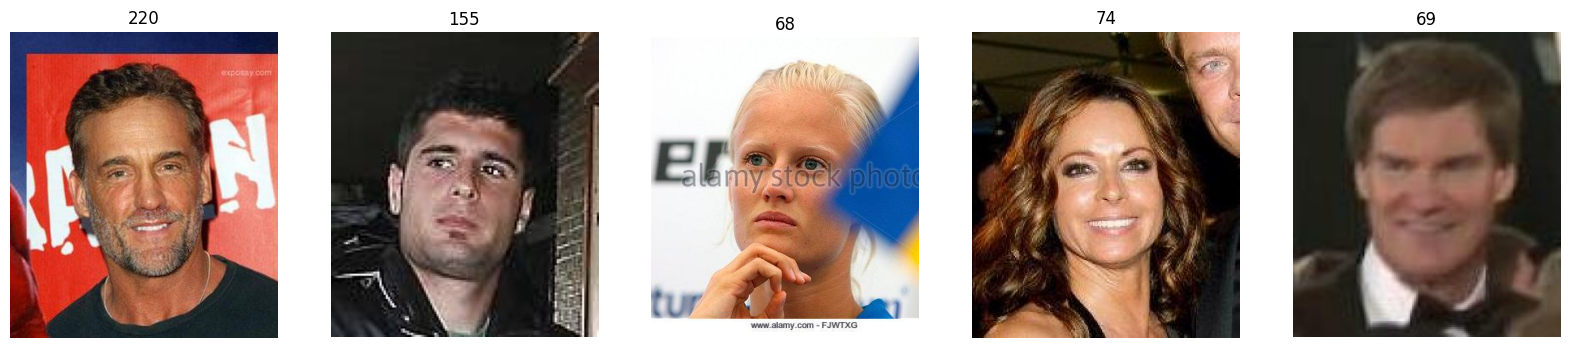

In [10]:
# plotting our data

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")
        
sample_images_to_visualize = [np.array(train_data[i]["image"]) for i in range(5)]
sample_captions = [train_data[i]["label"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [11]:
MODEL_NAME = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(MODEL_NAME)

In [12]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["label"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

train_data.set_transform(transforms)
test_data.set_transform(transforms)

In [13]:
wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [14]:
# loading model

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

In [15]:
# train the model

model_name = MODEL_NAME.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-faces",
    learning_rate=5e-5,
    num_train_epochs=2,
    fp16=True,
    disable_tqdm=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA devices.

In [51]:
# Set the root folder path
root_folder = '../datasets/lfw/train/'

# Get a list of all subfolder paths
subfolders = [f.path for f in os.scandir(root_folder) if f.is_dir()]

# Define the size of the images to load
img_size = (128, 128)

# Create an empty list to store the data
data = []

In [52]:
# Loop through each subfolder and extract the image data
for subfolder in subfolders:
    # Get the name of the subfolder
    name = os.path.basename(subfolder)
    # Loop through all the files in the subfolder
    for file in os.listdir(subfolder):
        # Check if the file is an image
        if file.endswith('.jpg'):
            # Get the path to the image file
            filepath = os.path.join(subfolder, file)
            # Load the image file using OpenCV
            img = cv2.imread(filepath)
            # Resize the image to the desired size
            img = cv2.resize(img, img_size)
            # Add the image data to the list
            data.append({'name': name, 'img': img})

# Create a Pandas dataframe from the image data
df = pd.DataFrame(data)

In [53]:
df.head()

,name,img
0,Aaron_Eckhart,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Aaron_Guiel,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Aaron_Patterson,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Aaron_Peirsol,"[[[240, 244, 238], [240, 244, 238], [240, 244,..."
4,Aaron_Peirsol,"[[[135, 49, 3], [136, 53, 5], [128, 52, 7], [1..."


In [61]:
import os

# Path to the parent folder
parent_folder = '../data/lfw-deepfunneled/lfw-deepfunneled/'

# Create an empty dictionary
folder_dict = {}

# Loop over all subfolders in the parent folder
for folder_name in os.listdir(parent_folder):
    folder_path = os.path.join(parent_folder, folder_name)
    # Check if the subfolder is actually a folder
    if os.path.isdir(folder_path):
        # Create a list to hold the image file names
        image_files = []
        # Loop over all files in the subfolder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            # Check if the file is a JPEG image
            if os.path.isfile(file_path) and file_name.lower().endswith(".jpg"):
                # Add the file name to the list of image files
                image_files.append(file_name)
        # Add the subfolder name as a key and the list of image files as the value to the dictionary
        folder_dict[folder_name] = image_files


In [64]:
folder_dict

{'Aaron_Eckhart': ['Aaron_Eckhart_0001.jpg'],
 'Aaron_Guiel': ['Aaron_Guiel_0001.jpg'],
 'Aaron_Patterson': ['Aaron_Patterson_0001.jpg'],
 'Aaron_Peirsol': ['Aaron_Peirsol_0001.jpg',
  'Aaron_Peirsol_0002.jpg',
  'Aaron_Peirsol_0003.jpg',
  'Aaron_Peirsol_0004.jpg'],
 'Aaron_Pena': ['Aaron_Pena_0001.jpg'],
 'Aaron_Sorkin': ['Aaron_Sorkin_0001.jpg', 'Aaron_Sorkin_0002.jpg'],
 'Aaron_Tippin': ['Aaron_Tippin_0001.jpg'],
 'Abbas_Kiarostami': ['Abbas_Kiarostami_0001.jpg'],
 'Abba_Eban': ['Abba_Eban_0001.jpg'],
 'Abdel_Aziz_Al-Hakim': ['Abdel_Aziz_Al-Hakim_0001.jpg'],
 'Abdel_Madi_Shabneh': ['Abdel_Madi_Shabneh_0001.jpg'],
 'Abdel_Nasser_Assidi': ['Abdel_Nasser_Assidi_0001.jpg',
  'Abdel_Nasser_Assidi_0002.jpg'],
 'Abdoulaye_Wade': ['Abdoulaye_Wade_0001.jpg',
  'Abdoulaye_Wade_0002.jpg',
  'Abdoulaye_Wade_0003.jpg',
  'Abdoulaye_Wade_0004.jpg'],
 'Abdulaziz_Kamilov': ['Abdulaziz_Kamilov_0001.jpg'],
 'Abdullah': ['Abdullah_0001.jpg',
  'Abdullah_0002.jpg',
  'Abdullah_0003.jpg',
  'Abdullah_0

Check the size of the dataset

In [55]:
print(df.shape)

(13233, 2)


Check for missing values

In [56]:
print(df.isna().sum())


name    0
img     0
dtype: int64


Compute and visualize the distribution of the name column

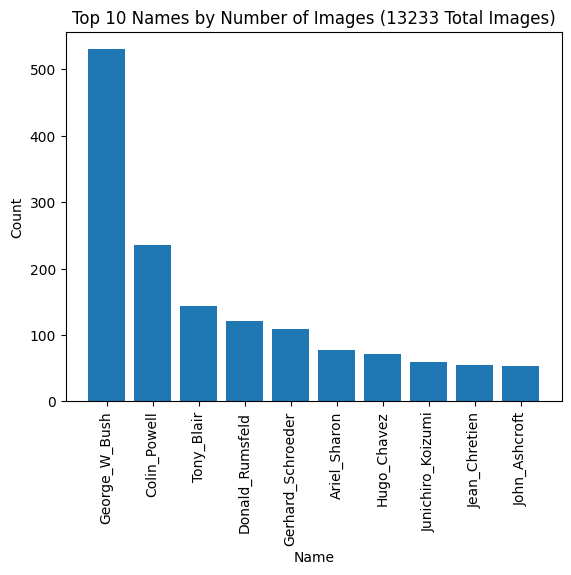

In [57]:
# Compute the number of unique names and images per name
name_counts = df['name'].value_counts()
n_names = len(name_counts)
n_images = sum(name_counts)

# Compute the top N names by number of images
top_n = 10
top_names = name_counts.index[:top_n]
top_counts = name_counts.values[:top_n]

# Plot the histogram
fig, ax = plt.subplots()
ax.bar(range(top_n), top_counts)
ax.set_xticks(range(top_n))
ax.set_xticklabels(top_names, rotation=90)
ax.set_xlabel('Name')
ax.set_ylabel('Count')
ax.set_title(f'Top {top_n} Names by Number of Images ({n_images} Total Images)')
plt.show()

Visualize a sample of the images

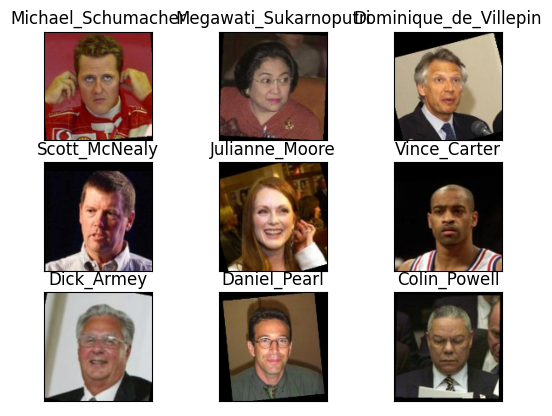

In [58]:
# Define the number of images to plot
n_images = 9

# Randomly sample the dataframe
sample_df = df.sample(n_images)

# Plot the images
fig, axes = plt.subplots(3, 3)
for i, (ax, img) in enumerate(zip(axes.flat, sample_df['img'])):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(sample_df.iloc[i]['name'])
plt.show()

Compute some basic summary statistics for the images

In [59]:
img_array = np.stack(df['img'].values)
print('Image array shape:', img_array.shape)
print('Pixel value range:', img_array.min(), '-', img_array.max())
print('Pixel value mean:', img_array.mean())
print('Pixel value std:', img_array.std())

Image array shape: (13233, 128, 128, 3)
Pixel value range: 0 - 255
Pixel value mean: 94.08819487831232
Pixel value std: 72.61633871914573


In [32]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [33]:

# Preprocess the data
input_shape = X_train.shape[1:]
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
X_train = X_train.reshape(X_train.shape[0], lfw_dataset.images.shape[1], lfw_dataset.images.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], lfw_dataset.images.shape[1], lfw_dataset.images.shape[2], 1)


In [18]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Epoch 1/20
15/15 [==============================] - 1s 32ms/step - loss: 1.5142 - accuracy: 0.4452 - val_loss: 1.4175 - val_accuracy: 0.4649
Epoch 2/20
15/15 [==============================] - 0s 19ms/step - loss: 1.4185 - accuracy: 0.4649 - val_loss: 1.4114 - val_accuracy: 0.4649
Epoch 3/20
15/15 [==============================] - 0s 18ms/step - loss: 1.4128 - accuracy: 0.4649 - val_loss: 1.4080 - val_accuracy: 0.4649
Epoch 4/20
15/15 [==============================] - 0s 19ms/step - loss: 1.4116 - accuracy: 0.4649 - val_loss: 1.4056 - val_accuracy: 0.4649
Epoch 5/20
15/15 [==============================] - 0s 20ms/step - loss: 1.4039 - accuracy: 0.4649 - val_loss: 1.4026 - val_accuracy: 0.4649
Epoch 6/20
15/15 [==============================] - 0s 20ms/step - loss: 1.4020 - accuracy: 0.4649 - val_loss: 1.3981 - val_accuracy: 0.4649
Epoch 7/20
15/15 [==============================] - 0s 21ms/step - loss: 1.4051 - accuracy: 0.4649 - val_loss: 1.3956 - val_accuracy: 0.4649
Epoch 8/20
15

In [19]:
# Make a prediction on a sample image
index = 1
img = X_test[index].reshape(lfw_dataset.images.shape[1:])
prediction = model.predict(np.expand_dims(img, axis=0))[0]
predicted_label = np.argmax(prediction)
predicted_name = names[predicted_label]


8/8 - 0s - loss: 1.3295 - accuracy: 0.4649 - 43ms/epoch - 5ms/step
Test accuracy: 0.4649122953414917


In [ ]:
# Display the image and the predicted name
plt.imshow(img)
plt.title(f"Predicted Name: {predicted_name}")
plt.show()

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set and calculate accuracy and confusion matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

## Data preprocessing

In [ ]:
data_dir = '../data/lfw-deepfunneled/lfw-deepfunneled/'
categories = os.listdir(data_dir)

images = []
labels = []

for category in categories:
    category_dir = os.path.join(data_dir, category)
    for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(category)
        
images = np.array(images)
labels = np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [5]:
# Get the unique labels seen during training
unique_labels = np.unique(y_train)

# Filter out the test samples with previously unseen labels
mask = np.isin(y_test, unique_labels)
test_images = X_test[mask]
test_labels = y_test[mask]

In [7]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
# Encode the labels
num_classes = len(unique_labels)
train_labels = to_categorical(y_test, num_classes)
test_labels = to_categorical(test_labels, num_classes)

ValueError: invalid literal for int() with base 10: 'Tim_Conway'

MODEL ARCHITECTURE

In [101]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

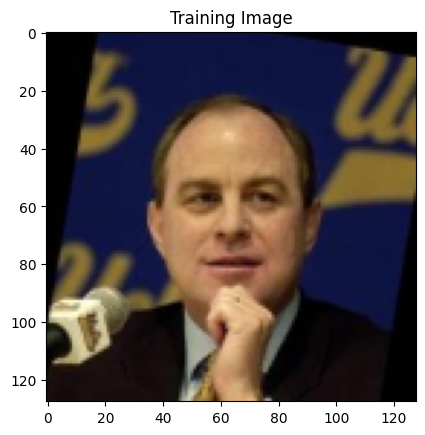

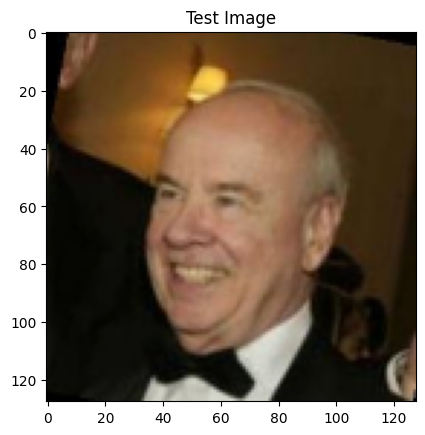

In [102]:
# Show one image from the training set
plt.imshow(X_train[0])
plt.title("Training Image")
plt.show()


# Show one image from the test set
plt.imshow(X_test[0])
plt.title("Test Image")
plt.show()

MODEL TRAIN

In [105]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Print the training loss and accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Print the validation loss and accuracy
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node 'Cast_25' defined at (most recent call last):
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\empar\AppData\Local\Temp\ipykernel_4204\153475041.py", line 25, in <module>
      history = model.fit(train_generator, epochs=10, validation_data=val_generator)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1055, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1149, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\metrics\base_metric.py", line 676, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_25'
Cast string to float is not supported
	 [[{{node Cast_25}}]] [Op:__inference_train_function_1299]

In [103]:

# Print the training loss and accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Print the validation loss and accuracy
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)


Epoch 1/10


ValueError: in user code:

    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\empar\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "conv2d_4" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 128, 128, 3)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=uint8)
      • training=True
      • mask=None


MODEL TEST

In [ ]:
# Load and preprocess the image
img = cv2.imread("path/to/new/image.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray, IMG_SIZE)
input_data = np.expand_dims(resized, axis=-1)
input_data = np.expand_dims(input_data, axis=0)
input_data = input_data.astype("float32") / 255.0

# Make a prediction with the model
pred = model.predict(input_data)

# Get the predicted class and its name
class_idx = np.argmax(pred)
name = names[class_idx]

print("Predicted name:", name)